In [ ]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

import statsmodels.api as sm
from patsy import dmatrices

import sys
sys.path.append('..')
import attrs, utils

In [9]:
# Load dataset and set tide gauges to consider
ds = xr.open_dataset(os.path.join(attrs.DATA_PATH, 'tide_gauges_1970-2017.nc'))
gauges = ['new_york_ny', 'san_francisco_ca', 'pensacola_fl', 'ishigaki']

In [10]:
def get_days_since_1970(timeseries):
    x = timeseries.time.data
    x = (x - np.datetime64('1970-01-01 12:00:00')) / 86400000000000
    x = x.astype(int)
    return x

In [11]:
def select_season(timeseries, season):
    return timeseries.where(timeseries.time.dt.season == season, drop=True)

In [12]:
def quantile_regression(timeseries, q):
    """
    Performs quantile regression, returns coefficents as xarray polyval object so that it can be 
    """
    # Configure data using patsy.dmatrices
    days = get_days_since_1970(timeseries)
    sea_level = timeseries.data
    df = pd.DataFrame.from_dict({
        'days' : days,
        'sea_level' : sea_level
    })
    y, x = dmatrices('sea_level ~ days', data=df, return_type='dataframe')

    # Perform quantile regression
    qr = sm.regression.quantile_regression.QuantReg(y, x)
    result = qr.fit(q=q)
    
    # Return predictions on all dates
    full_date_range = pd.date_range('1970-01-01', '2017-12-31', freq='D')
    num_days = len(full_date_range)
    x_full = pd.DataFrame.from_dict({
        'Intercept' : np.ones(num_days),
        'days' : np.arange(num_days)
    })
    prediction = result.predict(x_full)

    # Return as xarray.DataArray
    darray = xr.DataArray(
        prediction.values,
        dims=('time',),
        coords={'time': full_date_range})
    return darray

In [21]:
def plot_timeseries_and_dists(timeseries, ymin=None, ymax=None, 
    season='JJA', conf_bounds=None, bins=None):
    # Select season
    sea_level = select_season(timeseries, season)
    time = sea_level.time
    start_sl = sea_level.sel(time=slice('01-01-1970', '12-31-1979'))
    end_sl = sea_level.sel(time=slice('01-01-2008', '12-31-2017'))
    start_pd = start_sl.time
    end_pd = end_sl.time

    # Plot attributes
    color1 = 'tab:blue'
    color2 = 'tab:orange'
    if ymin is None:
        ymin = sea_level.min().item()
    if ymax is None:
        ymax = sea_level.max().item()
    ylim=(ymin, ymax)

    fig, axes = plt.subplots(
        figsize=(10,4),
        ncols=2, gridspec_kw={'width_ratios': [3, 1]}
    )

    # Plot observations
    sea_level.plot(
        ax=axes[0], ls='', marker='.', ms=3, alpha=0.5, color=(0.5,0.5,0.5), label='observations'
    )
    
    # Quantile regression
    # To do
    qs = [0.05, 0.5, 0.95]
    linestyles = iter([':', '-', ':'])
    for q in qs:
        pred = quantile_regression(sea_level, q)
        if conf_bounds is None:
            pred.plot(ax=axes[0], ls=next(linestyles), color='r',
                label='q={:.2f}'.format(q)
            )
        else:
            pred.plot(ax=axes[0], ls='--',
                label='q={:.2f}: {:5.3f} [{:5.3f}, {:5.3f}]'.format(
                    q, conf_bounds[q][0], conf_bounds[q][1], conf_bounds[q][2]
                )
            )

    # Add shading
    axes[0].fill_between(start_pd, ylim[1], color=color1, alpha=0.2)
    axes[0].fill_between(end_pd, ylim[1], color=color2, alpha=0.2)

    # Axis properties
    axes[0].set(
        title='{} sea level timeseries, {}'.format(sea_level.station_name, season),
        ylabel='Sea level [mm]'
    )
    axes[0].set_ylim(*ylim)
    axes[0].grid()
    axes[0].legend(loc='upper left')

    # Histograms
    if bins is None:
        # Shaded part
        axes[1].hist(
            start_sl, bins=30, range=ylim, density=True,
            histtype='stepfilled',
            orientation='horizontal',
            alpha=0.2, color=color1,
            label='1970-1979'
        )
        axes[1].hist(
            end_sl, bins=30, range=ylim, density=True,
            histtype='stepfilled',
            orientation='horizontal',
            alpha=0.2, color=color2,
            label='2008-2017'
        )
        # Outline part
        axes[1].hist(
            start_sl, bins=30, range=ylim, density=True,
            histtype='step', linewidth=2,
            orientation='horizontal',
        )
        axes[1].hist(
            end_sl, bins=30, range=ylim, density=True,
            histtype='step', linewidth=2,
            orientation='horizontal',
            alpha=1, color=color2,
        )
    else:
        axes[1].hist(
            start_sl, bins=bins, range=ylim, density=True,
            orientation='horizontal',
            alpha=0.5, color=color1,
            label='1970-1979'
        )
        axes[1].hist(
            end_sl, bins=bins, range=ylim, density=True,
            orientation='horizontal',
            alpha=0.5, color=color2,
            label='2008-2017'
        )

    axes[1].set(
        xlabel='Frequency',
        ylim=ylim
    )
    axes[1].grid()
    axes[1].legend(loc='upper right')

    fig.tight_layout()


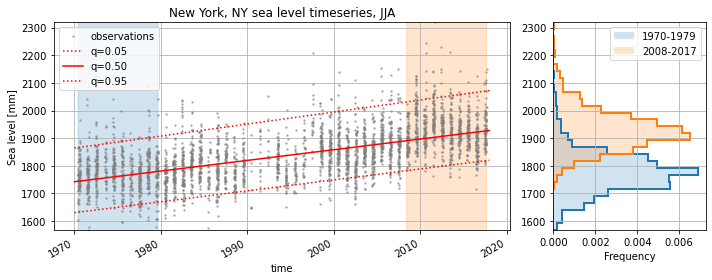

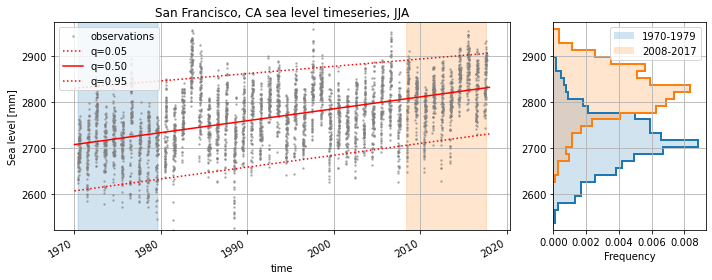

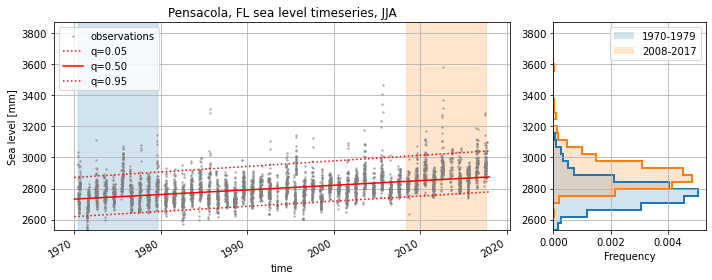

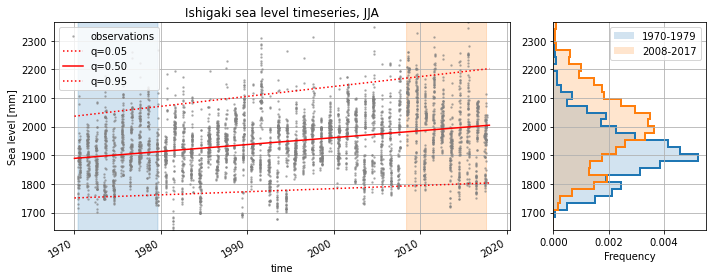

In [22]:
for gauge in gauges:
    timeseries = ds[gauge]
    plot_timeseries_and_dists(timeseries, season='JJA')